<h1 align='center' style='color:purple'>Credit Card Fraud - Imbalanced Data Set</h1>

In [1]:
# Import Libraries

import datetime

import random as rn
rn.seed(1) # random
import numpy as np
#from numpy.random import seed
np.random.seed(7) # or 7
import tensorflow as tf
tf.random.set_seed(0) # tf

import pandas as pd
import os
import tempfile

import matplotlib as mpl                                                                                             
if os.environ.get('DISPLAY','') == '':                                                                               
    print('no display found. Using non-interactive Agg backend')                                                     
    mpl.use('Agg')                                                                    
    
import matplotlib.pyplot as plt
if (os.environ.get('TERM','') == 'xterm-color'): 
    %matplotlib inline
elif (os.environ.get('TERM','') == 'cygwin'):
    print("shell terminal found")
else: # 'cygwin'
    print("no terminal found")
    
import pandas_profiling as pp
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer
from matplotlib import pyplot
import zipfile
import time

StartTime = datetime.datetime.now()


no display found. Using non-interactive Agg backend


In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [3]:
#print(os.environ)
print('TERM:', os.environ.get('TERM',''))

TERM: xterm-color


Always like to include a timer function to see where my code is running slow or taking most of the run time

In [4]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [5]:
def CalcPct(df,title):
    unique_elements, counts_elements = np.unique(df, return_counts=True)
    calc_pct = round(counts_elements[1]/(counts_elements[0]+counts_elements[1]) * 100,6)
    print(title)
    print(np.asarray((unique_elements, counts_elements)))
    return calc_pct

In [6]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')  
else:
    print("colab_gpu not found")

colab_gpu not found


Setup to run on Google Colab and Kaggle platforms

In [7]:
# Check if Google Colab path exists
if os.path.exists("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("/content/drive/My Drive/MyDSNotebooks/Imbalanced_data/input/creditcardzip")
# else check if Kaggle/local path exists
elif os.path.exists("../input/creditcardzip") :
    # Change the current working Directory    
    os.chdir("../input/creditcardzip")
else:
    print("Can't change the Current Working Directory") 
print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\input\creditcardzip


In [8]:
verbose=0
# Load the Data Set
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
#off line data source for backup
#df = pd.read_csv('creditcard.csv')

Public Credit Card Dataset. This is financial data, and is considered to be sensitive so it is "encrypted" through the use of PCA to protect privacy. Only the Time and Dollar columns are intact after the "encryption"

Doing some initial data exploration

In [9]:
# Check the data, make sure it loaded okay
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [10]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
# Check the Uniqueness
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [12]:
# Check for missing data
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [13]:
# Check basic Statistics
# looks like StandardScaler was performed on this dataset, mean is close to 0 for all columns

df.describe(include ='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

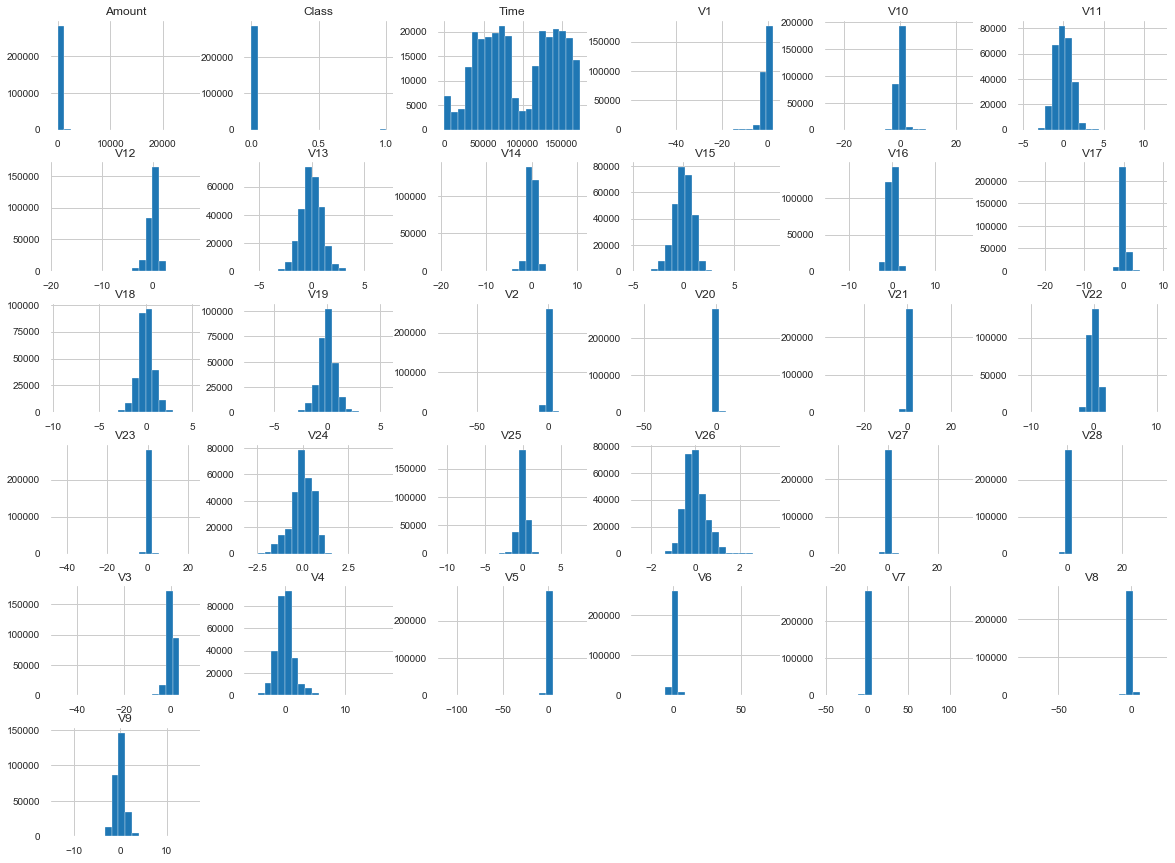

In [15]:
# Histograms of the features
# most of the data has a quasi-normal/gaussian distribution

df.hist(bins=20, figsize=(20,15))
plt.show()

Look at cross correlations between features. Most models will be fine with collinearity, but good to know this in any case. Most of my input is numerical, and my label is binary classification, so I can choose the Anova or Kendall's method. I will try the Kendall tau-b method first. This method will sort the 2 columns and compare if the X is always > or < Y. If so, the tau-b value will be 1.

Some key points to remember:
Kendall’s Tau: Calculations based on concordant and discordant pairs. Insensitive to error. P values are more accurate with smaller sample sizes. Good resource can be found here: https://online.stat.psu.edu/stat509/node/158/

This image shows which method you should choose based on your dataset:

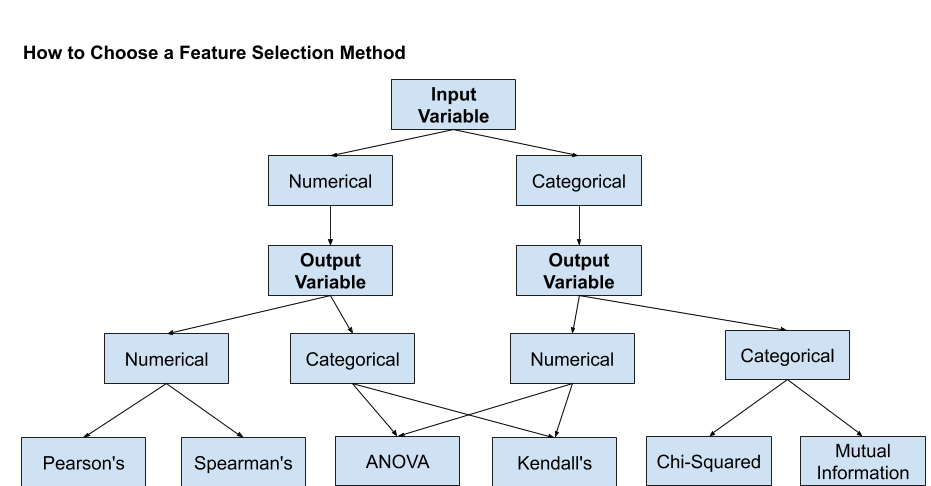

Text(0.5, 1.05, "Kendall'sCorrelation Matrix Full Data Set")

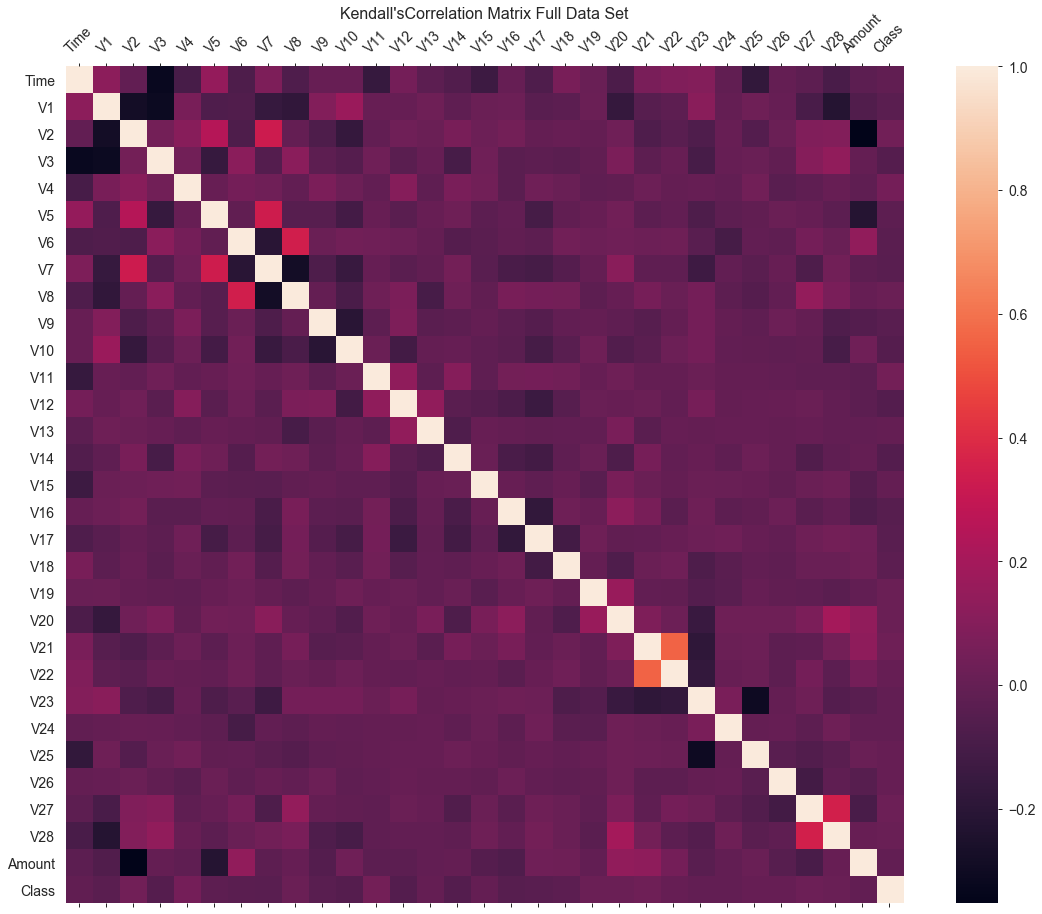

In [16]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall'sCorrelation Matrix Full Data Set", fontsize=16)

V21 and V22 show the highest tau-b score, will investigate this relationship later

In [17]:
#try some data cleansing, Amount has a few high values, so try using the log of that column instead.

temp_df = df.copy()
temp_df = temp_df.drop(['Time'], axis=1)
temp_df['Log_Amount'] = np.log(temp_df.pop('Amount')+0.001)
df = temp_df.copy()

In [18]:
from scipy.special import boxcox1p
lam = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,2,3]
for i in lam:
    print("lam:", i)
    X = df.loc[:, df.columns != 'Class']
    y = df.loc[:, df.columns == 'Class']
    norm = MinMaxScaler().fit(X)
    X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Pre", abs(skewness.Skew).mean())
    skewed_features = skewness.index
    lam_f = 0.0
    for feat in skewed_features:
        X[feat] = boxcox1p(X[feat], i)
    numeric_feats = X.dtypes[X.dtypes != "object"].index
    skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 2]
    skewness = skewness[skewness.Skew == skewness.Skew]
    print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    print("Post", abs(skewness.Skew).mean())

lam: 0
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.924619556314968
lam: 0.1
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.752674910071598
lam: 0.2
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.591619281099101
lam: 0.3
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 10 skewed numerical features to Box Cox transform
Post 5.4408440384190175
lam: 0.4
Pre: There are 12 skewed numerical features to Box Cox transform
Pre 4.3723215435489005
Post: There are 11 skewed numerical features to Box Cox transform
Post 5.019947162619655
lam: 0.5
Pre: There are 12 skewed numerical features to Box Cox transfo

In [19]:
from scipy.special import boxcox1p
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Pre: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Pre", abs(skewness.Skew).mean())
skewed_features = skewness.index
pt = PowerTransformer(method='yeo-johnson').fit(X)
X = pd.DataFrame(pt.transform(X), index=X.index, columns=X.columns)
numeric_feats = X.dtypes[X.dtypes != "object"].index
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1.0]
skewness = skewness[skewness.Skew == skewness.Skew]
print("Post: There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Post", abs(skewness.Skew).mean())

Pre: There are 17 skewed numerical features to Box Cox transform
Pre 3.514581911418132
Post: There are 8 skewed numerical features to Box Cox transform
Post 1.977383868458546


In [20]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V27,3.465013
V7,2.594561
V8,2.297578
V28,1.069187
V2,0.334850
V12,0.158932
V16,0.137436
V24,0.112492
V14,0.105965
V25,0.077895


Need to normalize the data before using boxcox or log transforms as they don't work on negative and 0 values

In [21]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
norm = MinMaxScaler().fit(X)
X = pd.DataFrame(norm.transform(X), index=X.index, columns=X.columns)

Pre-transform skew

In [22]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in all numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in all numerical features: 



,Skew
V28,11.192032
V21,3.592972
V7,2.553894
V6,1.826571
V10,1.187134
V4,0.676289
V26,0.576690
V9,0.554677
V11,0.356504
V19,0.109191


In [23]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} highly skewed numerical features to Box Cox transform".format(skewness.shape[0]))


There are 18 highly skewed numerical features to Box Cox transform


In [24]:
from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.0
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam_f)

Post-transform skew

In [25]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
V28,6.241873
V6,1.359141
V21,1.251583
V4,0.676289
V26,0.576690
V9,0.554677
V10,0.363269
V11,0.356504
V19,0.109191
V13,0.065233


In [26]:
skewness = skewness[abs(skewness) > 0.75]
skewness = skewness[skewness.Skew == skewness.Skew]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 16 skewed numerical features to Box Cox transform


so far the MinMaxScaler, boxcox1p and log1p transforms make the data more skewed...
just utilize the PowerTransformer instead, with yeo-johnson as there are many negative values

Divide the dataset into features and labels and then into Train, Test and Validate datasets

In [27]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']

# divide full data into features and label
spl1 = 0.36
spl2 = 0.44

OrigPct = CalcPct(y,"Original")

strat = True
if (strat == True):
    stratify=y['Class']
else:
    stratify="None"
# create train, test and validate datasets

# first split original into Train and Test+Val
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = spl1, random_state = None, shuffle=True, stratify=stratify)
# then split Test+Val into Test and Validate
# Validate will only be used in the 2 Model system (explained below)
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = spl2, random_state = None, shuffle=True)
y_train_orig = y_train.copy(deep=True)

Original
[[     0      1]
 [284315    492]]


The correct way to transform, fit the train data and transform train, test and val data based on the fit  
This does not have any effect on the performance of the model. Mean Specificity and Sensitivity are unchanged. Tested ~ 20 iterations

In [28]:
pt_tran = 0
if (pt_tran == 1):
    pt = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
    X_train = pd.DataFrame(pt.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test  = pd.DataFrame(pt.transform(X_test), index=X_test.index, columns=X_test.columns)
    X_val   = pd.DataFrame(pt.transform(X_val), index=X_val.index, columns=X_val.columns)

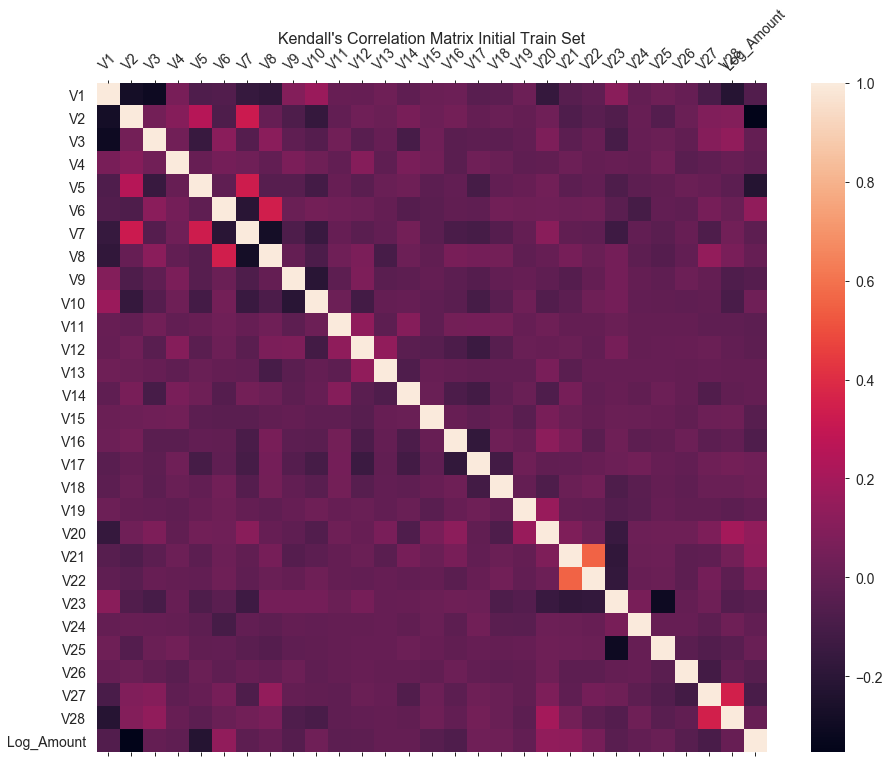

In [29]:
f = plt.figure(figsize=(16, 12))
plt.matshow(X_train.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
plt.show()

In [30]:
# prepare data for model, need to do this normalization and clipping separately for X_train, X_test and X_val 
# to avoid any contamination between Train and Test/Validate datasets

# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

save_data = 1
if (save_data == 1):
    df1 = train_df.copy()
    df1.to_csv('CCFraudTrain.csv', index=False)  
    df2 = test_df.copy()
    df2.to_csv('CCFraudTest.csv', index=False) 
    df3 = val_df.copy()
    df3.to_csv('CCFraudVal.csv', index=False) 

In [31]:
if (save_data == 1):
    train_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Train.csv')                                                                         
    test_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Test.csv')  
    val_df = pd.read_csv('C:\DataScience\Repo\Imbalanced_data\CreditCardFraud\working\Imb_Val.csv')     

In [32]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


In [33]:
class_names=[0,1] # name  of classes 1=fraudulent transaction

y_val['Class'].value_counts()

TrainPct = CalcPct(y_train,"Train")
TestPct = CalcPct(y_test,"Test")
ValPct = CalcPct(y_val,"Val")
zeros, ones = np.bincount(y_train['Class'])

Train
[[     0      1]
 [181961    315]]
Test
[[    0     1]
 [57312   105]]
Val
[[    0     1]
 [45042    72]]


Investigate the high tau-b value between V21 and V22

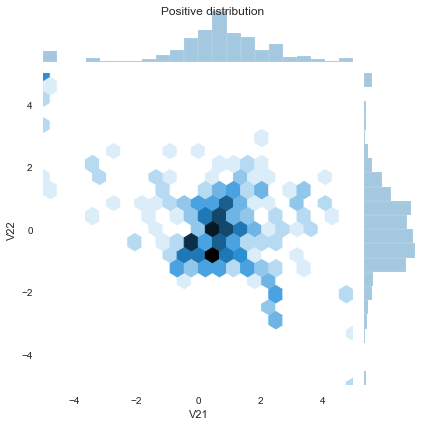

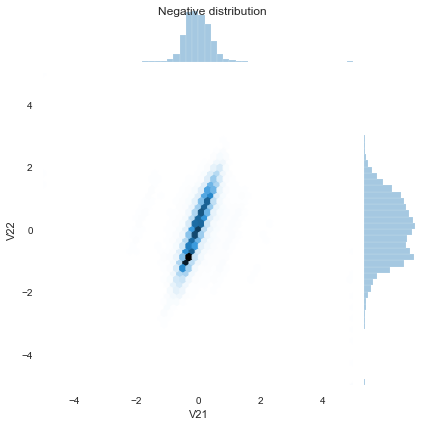

In [34]:
# Form np arrays of labels and features for jointplot charts

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = X.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = X.columns)
sns.jointplot(pos_df['V21'], pos_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")
sns.jointplot(neg_df['V21'], neg_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

V21 shows a slight one-sided tail, however Kendall's correlation test is good to use here as it is a non-parametric test and can handle non-gaussian distributions like this

For a imbalanced sampling strategy, I will be using undersampling in my project as i think this is the best approach for this type of data

In [35]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

y_train = np.array(y_train).flatten()

Create some calculation and visualization functions to show the results

In [36]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [37]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred, algo):
    model_probs = model_name.predict_proba(test_features)
    n = model_name.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error") 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    if (type(test_label) != np.ndarray):
        y = np.reshape(test_label.to_numpy(), -1)
    else:
        y = test_label
    fpr, tpr, thresholds = metrics.roc_curve(y, model_probs, pos_label=1)
    cm_results.append([algo, tn, fp, fn, tp])
    cr_results.append([algo, classification_report(test_label, pred)])
    roc.append([algo, fpr, tpr, thresholds])
    # AUC score should be (Sensitivity+Specificity)/2
    print(algo + ':TEST | AUC Score: ' + str( round(metrics.auc(fpr, tpr),3 )))
    return tn, fp, fn, tp

In [38]:
def auc_roc_metrics(model, test_features, test_labels, algo): # model object, features, actual labels, name of algorithm
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only
    n = model.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]  
    model_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo) 
    return model_auc

In [39]:
def auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo):
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 3)

    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [40]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [41]:
def prediction_cutoff(model, test_features, cutoff):
    model.predict_proba(test_features)
    # to get the probability in each class, 
    # for example, first column is probability of y=0 and second column is probability of y=1.

    # the probability of being y=1
    prob1=model.predict_proba(test_features)[:,1]
    predicted=[1 if i > cutoff else 0 for i in prob1]
    return predicted

In [42]:
metrics_results = {}
roc = []
cm_results = []
cr_results = []

run Logistic Regression model first

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

The 2 step process has the highest sensitivity (and specificity) between the models. The 2 step process also improves the overall model prediction of positives by a large amount (FP/TP ratio from above 10x to below 2x). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 10x FP/TP ratio.

Next will try a few Neural Networks

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

Using TensorFlow backend.


Adding swish activation function code for possible use later, can compare to relu, etc

In [45]:
# create new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [46]:
# add this function to the list of Activation functions
get_custom_objects().update({'swish': Activation(swish)})

Create the models to be used layer, using Sequential()

In [47]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.npv = []
        self.recall = []
        self.specificity = []
        self.f1s = []
        self.kappa = []
        self.auc = []

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]

        self.auc.append(sklm.roc_auc_score(targ, score))
        self.confusion.append(sklm.confusion_matrix(targ, predict))
        self.precision.append(sklm.precision_score(targ, predict))
        self.npv.append(sklm.precision_score(1-targ, 1-predict))
        self.recall.append(sklm.recall_score(targ, predict))
        self.specificity.append(sklm.recall_score(1-targ, 1-predict))
        self.f1s.append(sklm.f1_score(targ, predict))
        self.kappa.append(sklm.cohen_kappa_score(targ, predict))
        print('precision: ', sklm.precision_score(targ, predict))
        print('recall: ', sklm.recall_score(targ, predict))
        print('npv: ', sklm.precision_score(1-targ, 1-predict))
        print('specificity: ', sklm.recall_score(1-targ, 1-predict))

        return

In [48]:
import keras.backend as K
def custom_loss_abs_sum(y_true, y_pred):
    loss = abs(y_true - y_pred)
    return loss
#clf.compile(optimizer='adam', loss=custom_loss_abs_sum, metrics=['accuracy']) 

In [49]:
# list of all metrics: https://www.tensorflow.org/api_docs/python/tf/keras/metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.BinaryCrossentropy(name='crossentropy', from_logits=False, label_smoothing=0),
      keras.metrics.SensitivityAtSpecificity(specificity=0.0, num_thresholds=200, name='sensitivity'),  # (tp / (tp + fn)).
      keras.metrics.SpecificityAtSensitivity(sensitivity=0.0, num_thresholds=200, name='specificity'),   # (tn / (tn + fp)).
      keras.metrics.CosineSimilarity(name='cosine_similarity', axis=-1),
      keras.metrics.KLDivergence(name='kl_divergence'),
      keras.metrics.LogCoshError(name='logcosh'),
]

Now run the basic DNN (Deep Neural Network)

for Custom Loss fit to Train dataset (balanced):  

Use Keras/Tensor math functions!  
reference: https://www.tensorflow.org/api_docs/python/tf/keras/backend/  

Predictions on test dataset:  

loss = y_true - y_pred => all predictions are 1, fn are loss=+1, fp are loss=-1  
[[    0 59708]  
[    0   102]]  

loss = y_pred - y_true => all predictions are 0, fp are loss=+1, fn are loss=-1  
[[59708     0]  
 [  102     0]]  
 
loss = abs(y_true - y_pred) => all mistakes have equal weight  

[[57693  2015]  
 [   12    90]]  

In [50]:
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/

import keras.backend as K
def custom_loss_mask(y_true, y_pred):
    #loss = abs(y_true - y_pred)
    
    mask1 = K.less(y_pred, y_true) # is y_pred < y_true or y_pred - y_true < 0, FN
    mask2 = K.less(y_true, y_pred) # is y_true < y_pred or y_true - y_pred < 0, FP
    #loss = K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred) # only include FN
    loss = (K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred)) + (K.cast(mask2, K.floatx()) * 4 * (y_pred - y_true)) # only include FN
    return loss
#clf.compile(optimizer='adam', loss=custom_loss_mask, metrics=['accuracy']) 

In [51]:
# define variable learning rate function
from keras.callbacks import LearningRateScheduler, EarlyStopping, History, LambdaCallback
import math

def step_decay(epoch, lr):
    drop = 0.995 # was .999
    epochs_drop = 5.0 # was 175, sgd likes 200+, adam likes 100
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("epoch=" + str(epoch) + " lr=" + str(lr) + " lrate=" + str(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto', restore_best_weights = True)
callbacks_list = [lrate, early_stopping] 

In [52]:
def create_dnn(input_dim):
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=input_dim, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,695
Trainable params: 1,695
Non-trainable params: 0
____________________________________________________

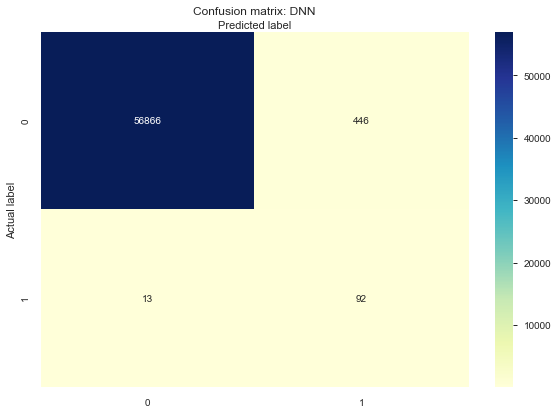

  No Skill : ROC AUC=0.500
       DNN : ROC AUC=0.943


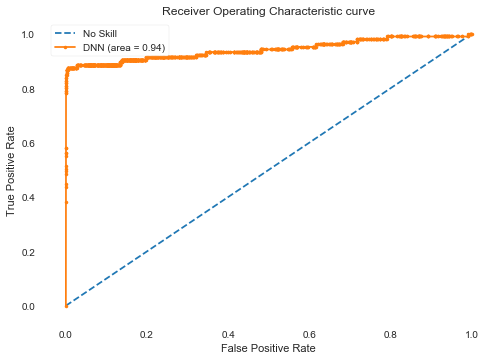

In [53]:
from keras.optimizers import Adam, SGD, RMSprop

verbose=1
clf = create_dnn(X_train.shape[1])
clf.summary()
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

learning_rate = 0.0001
decay = 0.0002
momentum=0.99
opt_sel = "adam"
if (opt_sel == "adam"):
    #opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad) # added to v86
    opt = Adam(lr=learning_rate)
elif(opt_sel == "sgd"):
    opt = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay, nesterov=True)

clf.compile(optimizer=opt, loss=custom_loss_mask, metrics=['accuracy'])

#adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
#clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=200, verbose=verbose, 
        sample_weight=np.where(y_train == 1,1.0,1.0).flatten(), 
        callbacks=callbacks_list, validation_data=(X_val, y_val))

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=verbose)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=verbose)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN')
visualize(y_test, yhat_classes, 'DNN')
dnn_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN')
metrics_results['dnn'] = dnn_auc

In [54]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'accuracy', 'crossentropy','fn','fp']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,4,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        elif metric == 'fn':
            plt.ylim([0,100])
        elif metric == 'fp':
            plt.ylim([0,5000])
        elif metric == 'accuracy':
            plt.ylim([0.8,1])
        elif metric == 'crossentropy':
            plt.ylim([0,0.2])
        elif metric == 'precision':
            plt.ylim([0,0.2])
        elif metric == 'recall':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [55]:
#import keras.backend as K                                                                                         
def custom_loss(y_true, y_pred):                                                                                   
    #loss = abs(y_true - y_pred)                                                                                   
    mask1 = K.less(y_pred, y_true) # is y_pred < y_true or y_pred - y_true < 0, FN                                 
    mask2 = K.less(y_true, y_pred) # is y_true < y_pred or y_true - y_pred < 0, FP                                 
    #loss = K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred) # only include FN                                    
    loss = (K.cast(mask1, K.floatx()) * 2 * (y_true - y_pred)) + (K.cast(mask2, K.floatx()) * 4 * (y_pred - y_true) ) # FP has higher penalty                                                                                          
    return loss 

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

def custom_loss_function(y_true, y_pred):
    squared_difference = K.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

def make_model(metrics = METRICS, output_bias=-100):
    #if output_bias is not None:
    print('func_output_bias:', output_bias)
    
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          #keras.metrics.BinaryCrossentropy(name='crossentropy', from_logits=False, label_smoothing=0),
          keras.metrics.BinaryCrossentropy(name='crossentropy'),
          keras.metrics.SensitivityAtSpecificity(specificity=0.0, num_thresholds=200, name='sensitivity'),  # (tp / (tp + fn)).
          keras.metrics.SpecificityAtSensitivity(sensitivity=0.0, num_thresholds=200, name='specificity'),   # (tn / (tn + fp)).
          keras.metrics.CosineSimilarity(name='cosine_similarity', axis=-1),
          keras.metrics.KLDivergence(name='kl_divergence'),
          #custom_loss_mask,
          #custom_loss_function
    ]

    if (output_bias > -50):
        print("output_bias passed in:", output_bias)
        use_bias_sel = True
        output_bias = keras.initializers.Constant(output_bias)
        clf = Sequential([
                Dense(units=16, activation='relu', input_shape=(train_features.shape[-1],)),
                Dropout(0.50),
                Dense(units=1, activation='sigmoid', use_bias=use_bias_sel, bias_initializer=output_bias),
            ])
    else:
        print("output_bias not passed in")
        use_bias_sel = False
        clf = Sequential([
                Dense(units=16, activation='relu', input_shape=(train_features.shape[-1],)),
                Dropout(0.50),
                Dense(units=1, activation='sigmoid'),
            ])

    clf.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        #loss=custom_loss_mask,
        #loss=custom_loss_function,
        metrics=METRICS)

    return clf;

In [56]:
# use model from imbalanced_data notebook

BATCH_SIZE = 2048
EPOCHS = 100
neg, pos = np.bincount(train_labels)
total = neg + pos
initial_bias = np.log([pos/neg])
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('initial_bias:', initial_bias)
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1));

initial_bias: [-6.38474387]
Weight for class 0: 0.50
Weight for class 1: 296.87


In [57]:
def RunModel(mon='val_auc', mod='max'):
    #First Pass
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=mon, verbose=0, patience=25, mode=mod, restore_best_weights=True)

    clf = make_model(output_bias = initial_bias)
    
    clf.fit(
        train_features,
        train_labels,
        initial_epoch=0,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        shuffle=False,
        # The class weights go here
        class_weight=class_weight
    ) 
    
    #clf.fit(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)#, shuffle=False)
    
    #evaluate does not change or train the model, think this can be skipped unless we want the loss metric
    results = clf.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

    # 12/18 before removing these 4 lines
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    clf.save_weights(initial_weights)

    #clf = make_model()
    clf = make_model(output_bias = initial_bias)
    clf.load_weights(initial_weights)

    weighted_history = clf.fit(
        train_features,
        train_labels,
        initial_epoch=0,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        shuffle=False,
        # The class weights go here
        class_weight=class_weight
    ) 

    yhat_classes = clf.predict_classes(test_features, verbose=verbose, batch_size=BATCH_SIZE)
    yhat_classes = yhat_classes[:, 0]
    print("mon='", mon, "',mod='", mod)
    print(metrics.confusion_matrix(test_labels, yhat_classes))
    tn, fp, fn, tp = display_metrics(clf, train_features, test_features, train_labels, test_labels, yhat_classes, 'DNN Weighted')
    dnn_weighted_auc = auc_roc_metrics(clf, test_features, test_labels, 'DNN-Weighted')
    metrics_results['dnn_weighted'] = dnn_weighted_auc
    return (weighted_history);

func_output_bias: [-6.38474387]
output_bias passed in: [-6.38474387]
Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 5s 28us/step - loss: 1.5790 - tp: 114.0000 - fp: 266.0000 - tn: 181703.0000 - fn: 193.0000 - accuracy: 0.9975 - precision: 0.3000 - recall: 0.3713 - auc: 0.7769 - crossentropy: 0.0172 - sensitivity: 1.0000 - specificity: 1.0000 - cosine_similarity: 0.0017 - kl_divergence: 0.0053 - val_loss: 0.0102 - val_tp: 63.0000 - val_fp: 12.0000 - val_tn: 45472.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8400 - val_recall: 0.7412 - val_auc: 0.9375 - val_crossentropy: 0.0102 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_cosine_similarity: 0.0019 - val_kl_divergence: 0.0020
Epoch 2/100
182276/182276 [==============================] - 4s 22us/step - loss: 0.7356 - tp: 204.0000 - fp: 631.0000 - tn: 181338.0000 - fn: 103.0000 - accuracy: 0.9960 - precision: 0.2443 - recall: 0.6645 - auc: 0.892

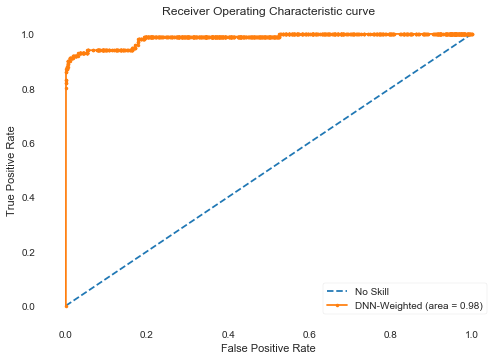

The function took 537.1929943561554 seconds to complete


In [58]:
with MyTimer():
    weighted_history = RunModel(mon='val_auc', mod='max');
    #weighted_history = RunModel(mon='val_loss', mod='min');

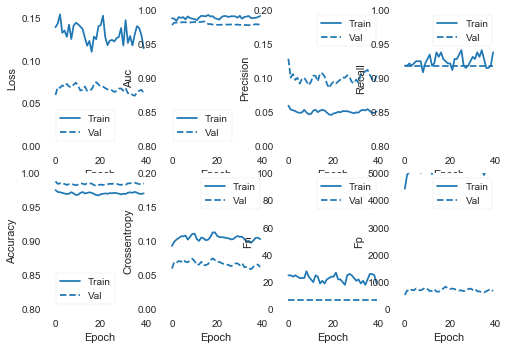

In [59]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(weighted_history)

In [60]:
# show all variables in memory
#%who or %whos

Here are the final results in tabular form. 

In [61]:
final_results = pd.DataFrame(cm_results, columns=('algo','TN','FP','FN','TP')) 
#sp = round((tn1 + tn2)/(tn1 + tn2 +fp2), 3)
#se = round(tp2/(tp2 + fn1 + fn2), 3)
final_results['SP'] = round(final_results['TN']/(final_results['TN'] + final_results['FP']), 3)
final_results['SE'] = round(final_results['TP']/(final_results['TP'] + final_results['FN']), 3)
final_results['Avg'] = (final_results['SP'] + final_results['SE'])/2
print('test, val, split settings')
print(spl1,spl2)
print('test, val, split sizes')
print( (spl1-spl1*spl2), (spl1*spl2) )
filtered = final_results[~final_results.algo.str.contains('a', regex= True, na=False)]
sort = filtered.sort_values(filtered.columns[7], ascending = False)
print(sort)
sort.to_csv('c:\\DataScience\\Repo\\Imbalanced_data\\CreditCardFraud\\working\\results.csv', sep=',', mode='a', encoding='utf-8', header=True)


test, val, split settings
0.36 0.44
test, val, split sizes
0.2016 0.15839999999999999
           algo     TN   FP  FN  TP     SP     SE     Avg
1  DNN Weighted  56033  829   9  91  0.985  0.910  0.9475
0           DNN  56866  446  13  92  0.992  0.876  0.9340


In [62]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-09-25 20:09:06.999256
End:  2020-09-25 20:29:49.582630


In [63]:
#%reset -f